# GATE: Listmode, Random+Scatter Estimation

In [1]:
from __future__ import annotations
import torch
import pytomography
from pytomography.metadata import ObjectMeta, PETLMProjMeta, PETTOFMeta, PETSinogramPolygonProjMeta
from pytomography.projectors.PET import PETLMSystemMatrix, PETSinogramSystemMatrix
from pytomography.algorithms import OSEM
from pytomography.io.PET import gate, shared
from pytomography.likelihoods import PoissonLogLikelihood
import os
from pytomography.transforms.shared import GaussianFilter
import numpy as np
import nibabel as nib
import matplotlib.pyplot as plt
from pytomography.io.PET import sss
from pytomography.io.PET.shared import sinogram_coordinates, sinogram_to_spatial

Required data:

In [2]:
path = '/disk1/pet_mri_scan/'
macro_path = os.path.join(path, 'mMR_Geometry.mac') 
info = gate.get_detector_info(path = macro_path,
    mean_interaction_depth=9, min_rsector_difference=0)
scanner_LUT = gate.get_scanner_LUT(info)
# Get detector IDs from GATE file
paths = [os.path.join(path, f'gate_simulation/all_physics/mMR_voxBrain_{i}.root') for i in range(1, 55)]; del(paths[23])
macro_path = os.path.join(path, 'mMR_Geometry.mac')

Before we delve into scatter/random modeling, lets get a baseline reconstruction that uses only primary events from the simulated GATE data. We can use PyTomography functionality to select for such events when we open the ROOT data. Obviously this is not doable for clinical data (where we don't know which events are randoms/scatters).

In [3]:
detector_ids = gate.get_detector_ids_from_root(
    paths,
    macro_path,
    include_randoms=False,
    include_scatters=False)

Now we can reconstruct as we did in the introductory tutorials.

In [4]:
object_meta = ObjectMeta(
    dr=(2,2,2), #mm
    shape=(128,128,96) #voxels
)
weights_sensitivity = torch.load(os.path.join(path, 'norm_factor_lm.pt')) # Assume saved from introductory tutorial
atten_map = gate.get_attenuation_map_nifti('/disk1/pet_mri_scan/fdg_pet_phantom_umap.nii.gz', object_meta).to(pytomography.device)
proj_meta = PETLMProjMeta(
    detector_ids,
    info,
    weights_sensitivity=weights_sensitivity
    )
psf_transform = GaussianFilter(4) # 2mm gaussian blurring
system_matrix = PETLMSystemMatrix(
    object_meta,
    proj_meta,
    obj2obj_transforms = [psf_transform],
    attenuation_map = atten_map,
    N_splits=8,
)
likelihood = PoissonLogLikelihood(
    system_matrix,
    projections=torch.tensor([1.]).to(pytomography.device)
)
recon_algorithm = OSEM(likelihood)
recon_primaryonly = recon_algorithm(n_iters=50, n_subsets=1)

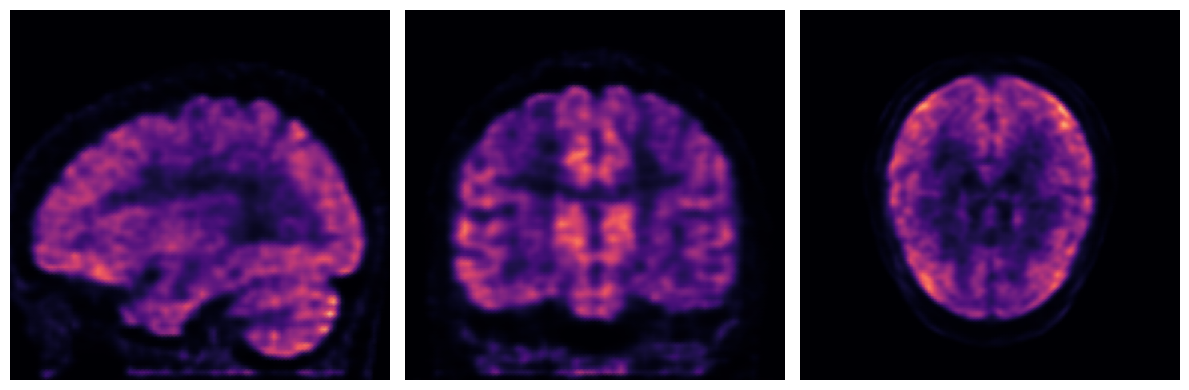

In [5]:
vmax = 0.15
fig, ax = plt.subplots(1,3,figsize=(12,4))
plt.subplot(131)
plt.pcolormesh(recon_primaryonly[0,48,16:-16].cpu().T, cmap='magma', shading='gouraud', vmax=vmax)
plt.axis('off')
plt.subplot(132)
plt.pcolormesh(recon_primaryonly[0,16:-16,64].cpu().T, cmap='magma', shading='gouraud', vmax=vmax)
plt.axis('off')
plt.subplot(133)
plt.pcolormesh(recon_primaryonly[0,:,:,48].cpu().T, cmap='magma', shading='gouraud', vmax=vmax)
plt.axis('off')
fig.tight_layout()
plt.show()

## Reconstructing With Random/Scatter Estimation

Get all events:

In [6]:
detector_ids = gate.get_detector_ids_from_root(
    paths,
    macro_path)

cpu


### Randoms

For random estimation, we still need to estimate in sinogram format, and then convert to listmode after we apply smoothing:

In [7]:
detector_ids_randoms = gate.get_detector_ids_from_root(
    paths,
    macro_path,
    substr = 'delay')
sinogram_random = gate.listmode_to_sinogram(detector_ids_randoms, info)
sinogram_random = gate.smooth_randoms_sinogram(sinogram_random, info, sigma_r=4, sigma_theta=4, sigma_z=4)
lm_randoms = shared.sinogram_to_listmode(detector_ids, sinogram_random, info)

### Scatters

Now we can reconstruct (without scatter correction) to get an initial PET image used as a proxy for scatter correction:

In [8]:
atten_map = gate.get_attenuation_map_nifti('/disk1/pet_mri_scan/fdg_pet_phantom_umap.nii.gz', object_meta)
norm_factor = torch.load(os.path.join(path, 'norm_factor_lm.pt'))
proj_meta = PETLMProjMeta(
    detector_ids[:,:2],
    info,
    weights_sensitivity=norm_factor
    )
psf_transform = GaussianFilter(4)
system_matrix = PETLMSystemMatrix(
       object_meta,
       proj_meta,
       obj2obj_transforms = [psf_transform],
       N_splits=10,
       attenuation_map=atten_map.to(pytomography.device),
)
# Get additive term (without scatter term):
lm_norm = system_matrix.compute_sensitivity_proj(all_ids=False)
additive_term = lm_randoms / lm_norm
additive_term[additive_term.isnan()] = 0 # remove NaN values
# Recon
likelihood = PoissonLogLikelihood(
        system_matrix,
        torch.tensor([1.]).to(pytomography.device),
        additive_term = additive_term
    )
recon_algorithm = OSEM(likelihood)
recon_without_scatter_estimation = recon_algorithm(50,1)

Now we estimate the scatter sinogram as we did before, and then convert to listmode after. Note that we still provide the sinogram of randoms (even though we're reconstructing listmode)

In [9]:
sinogram_scatter = sss.get_sss_scatter_estimate(
    object_meta = object_meta,
    proj_meta = proj_meta,
    pet_image = recon_without_scatter_estimation,
    attenuation_image = atten_map,
    system_matrix = system_matrix,
    proj_data = None, # assumes listmode
    image_stepsize = 4,
    attenuation_cutoff = 0.004,
    sinogram_interring_stepsize = 4,
    sinogram_intraring_stepsize = 4,
    sinogram_random = sinogram_random
    )
# Now convert to listmode
lm_scatter = shared.sinogram_to_listmode(proj_meta.detector_ids, sinogram_scatter, proj_meta.info)

/data/anaconda/envs/pytomo_install_test/lib/python3.11/site-packages/torch/functional.py:504: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at ../aten/src/ATen/native/TensorShape.cpp:3526.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]


Now we can redefine our additive term to include scatter information and reconstruct:

In [10]:
additive_term = (lm_scatter + lm_randoms) / lm_norm
additive_term[additive_term.isnan()] = 0
likelihood = PoissonLogLikelihood(
        system_matrix,
        torch.tensor([1.]).to(pytomography.device),
        additive_term = additive_term
    )
recon_algorithm = OSEM(likelihood)
recon_lm_nontof = recon_algorithm(50,1)

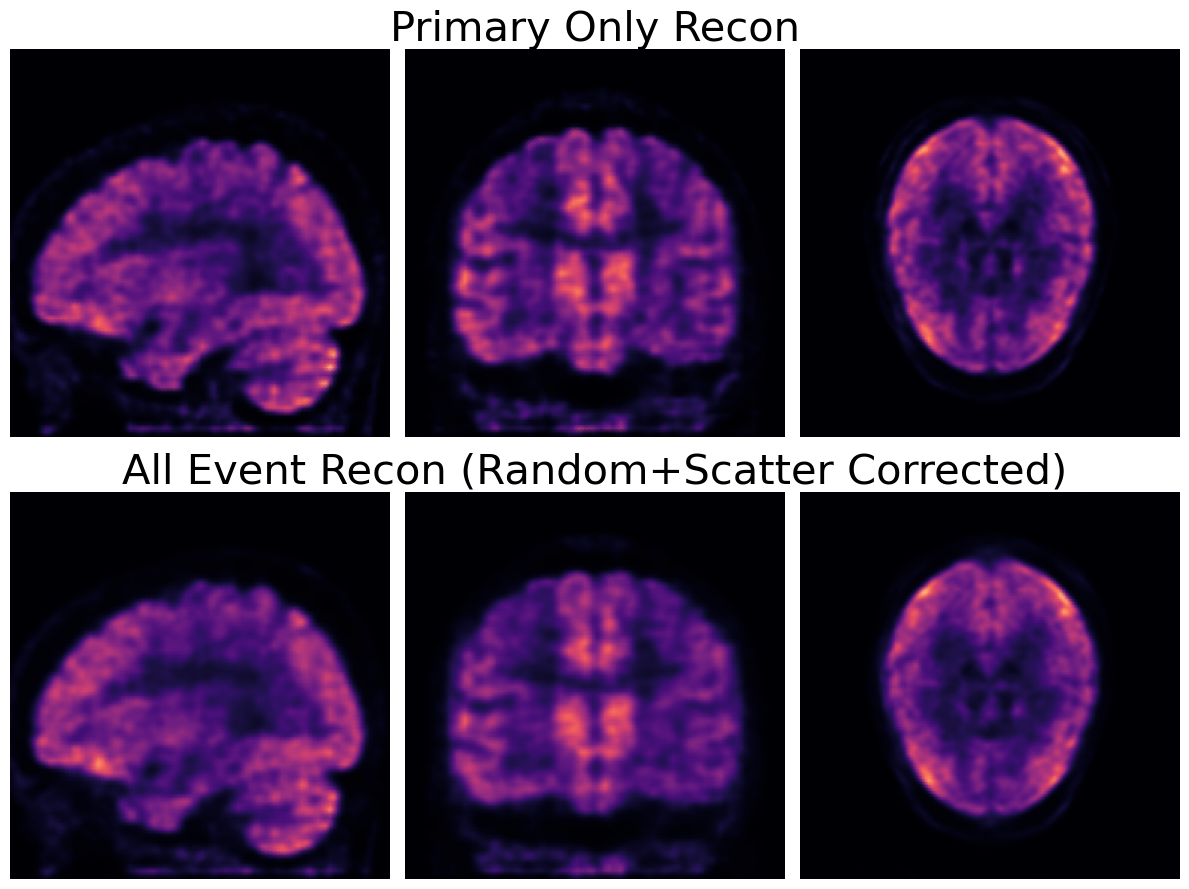

In [11]:
vmax = 0.15
fig, ax = plt.subplots(2,3,figsize=(12,9))
plt.subplot(231)
plt.pcolormesh(recon_primaryonly[0,48,16:-16].cpu().T, cmap='magma', vmax=vmax, shading='gouraud')
plt.axis('off')
plt.subplot(232)
plt.pcolormesh(recon_primaryonly[0,16:-16,64].cpu().T, cmap='magma', vmax=vmax, shading='gouraud')
plt.title('Primary Only Recon', fontsize=30)
plt.axis('off')
plt.subplot(233)
plt.pcolormesh(recon_primaryonly[0,:,:,48].cpu().T, cmap='magma', vmax=vmax, shading='gouraud')
plt.axis('off')
plt.subplot(234)
plt.pcolormesh(recon_lm_nontof[0,48,16:-16].cpu().T, cmap='magma', vmax=vmax, shading='gouraud')
plt.axis('off')
plt.subplot(235)
plt.pcolormesh(recon_lm_nontof[0,16:-16,64].cpu().T, cmap='magma', vmax=vmax, shading='gouraud')
plt.axis('off')
plt.title('All Event Recon (Random+Scatter Corrected)', fontsize=30)
plt.subplot(236)
plt.pcolormesh(recon_lm_nontof[0,:,:,48].cpu().T, cmap='magma', vmax=vmax, shading='gouraud')
plt.axis('off')
fig.tight_layout()
plt.show()